# Introduction

We will consider the general task of document classification using a variety of deep neural networks. Specifically, we will consider a binary sentiment classification task on the IMDb movie reviews dataset. We will train three different models for this common task: a simple dense architechture, a convolutional architechture, and a recurrent network architechture. We will then compare the qualities of the three networks to each other.

The following sources have been used to varying extents.

- [Word Embeddings](https://www.tensorflow.org/tutorials/text/word_embeddings)
- [Basic Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification)
- [RNN Text Classification](https://www.tensorflow.org/tutorials/text/text_classification_rnn)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds

import numpy as np

# Loading Data and Preprocessing

First, we need to load the dataset we will be using. Much of this process was covered in a separate notebook analyzing the imdb_reviews dataset, so we will move through this without too much discussion.

In [2]:
class_map = {0:'Negative', 1:'Positive'}
batch_size = 128 #Batch size for training

When we load the dataset below we take 20% of the training split and set that as the validation data.

In [3]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', data_dir='imdb', 
                            split=['train[:80%]','train[80%:]','test'],
                            as_supervised=True, batch_size=batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to imdb/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


We define a text normalization/standardization function below that will help us clean our input data. The text is converted to lowercase with punctuation and other artifacts like HTML removed. Removing stopwords was considered, but some of the TensorFlow regex functionality seems to be broken which made it more difficult than it was worth.

In [5]:
from tensorflow.strings import regex_replace, lower, split, join
import re
import string
# from nltk.corpus import stopwords

# sw = stopwords.words('english')

def normalize(data):
    data = lower(data)
    data = regex_replace(data, '<.*?>+', '') #html tags
    data = regex_replace(data, '\[.*?\]', '') #things in brackets
    data = regex_replace(data, 'https?:\/\/\S+|www\.\S+', '') #urls
    data = regex_replace(data, '\n', '') #newlines
    data = regex_replace(data, '\w*\d\w*', '') #char digit sandwiches
    
    #Do puncutation at end
    data = regex_replace(data, '[%s]' % re.escape(string.punctuation), '')
    
    return data

def removeStopWords(data):
    text = join([word for word in split(data) if word not in sw])
    return text

# Networks

With our dataset mostly ready to go we will move on to building and training our various models. There are a few common tasks we can take care of first: setting hyperparameters and vectorizing our text.

In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
epochs = 10
embed_dim = 100
vocab_size = 1000
max_len = 500

We will train for a maximum of 10 epochs, embed our words as 100 dimensional vectors, and only retain the top 1,000 most common words in our vocabulary. In the following code we build a text vectorization layer, which will tokenize our corpus, and apply it to our dataset. We note that we only adapt our vectorizer on the training dataset.

In [8]:
vectorizer = layers.experimental.preprocessing.TextVectorization(
        standardize=normalize, max_tokens=vocab_size, 
        output_sequence_length=max_len)

vectorizer.adapt(train_ds.map(lambda x,y: x))

In [9]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorizer(text), label

In [10]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

In [11]:
vocab = np.array(vectorizer.get_vocabulary())

for example, label in train_ds.take(1):
    print('Sequence Length: {}\n'.format(len(example[0])))
    text = ' '.join(vocab[example[0]])
    print('Text: {}\n'.format(text))
    print('Label: {}'.format(label[0]))

Sequence Length: 500

Text: this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK] us [UNK] piece the most [UNK] scenes were those when the [UNK] [UNK] were making their [UNK] for [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] and her [UNK] [UNK] with [UNK] was nothing but a [UNK] emotional [UNK] in a movie that was [UNK] of any real [UNK] i am disappointed that there are movies like this [UNK] actors like [UNK] [UNK] good name i could [UNK] sit through it                                                                                                                                                                                                                                                                                                                                                       

In the output above we can see the text and label for the first example in our dataset. The '\[UNK\]' symbol represents words that were excluded from our vocabulary and are thus unknown. By making our vocabulary size bigger we could include more words, but it seems like the sentiment is preserved in the above example. We also note that the sequence length is reported as 500, but the output string certainly isn't that long. This is happening because the sequences are padded to be as long as the max length sequence, but that padding corresponds to empty strings. We will see that for the dense and recurrent models below this doesn't make a difference, but for the convolutional model it really matters.

The last thing we do is setup a callback to stop training if the validation accuracy is plateauing, and set up our dataset for performance.

In [12]:
monitor = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2,
                                        mode='max')

In [13]:
#Performance configuration
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Dense

Below we define a simple densely connected model. We use a global average pooling layer to deal with the varying sequence lengths, and our final output is a number between 0 and 1 (i.e. our two classes). Essentially we average our input and then run it through a series of densely connected layers to predict one of two classes.

In [14]:
dense = keras.models.Sequential([
    layers.Embedding(vocab_size, embed_dim, mask_zero=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

print(dense.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

We can see that we have about 140,000 parameters, although most of those are from the embedding. We will try to keep this value mostly constant among our different model architechtures.

In [15]:
dense.compile(optimizer='Adam',
             loss=keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

Our loss function is binary crossentropy as we are only considering two classes. Next we train...

In [16]:
d_history = dense.fit(train_ds, validation_data=val_ds, epochs=epochs,
                     callbacks=[monitor])

Epoch 1/10
157/157 [==============================] - 6s 30ms/step - loss: 0.6202 - accuracy: 0.6439 - val_loss: 0.3542 - val_accuracy: 0.8472
Epoch 2/10
157/157 [==============================] - 4s 27ms/step - loss: 0.3492 - accuracy: 0.8517 - val_loss: 0.3405 - val_accuracy: 0.8552
Epoch 3/10
157/157 [==============================] - 4s 28ms/step - loss: 0.3285 - accuracy: 0.8656 - val_loss: 0.3424 - val_accuracy: 0.8568
Epoch 4/10
157/157 [==============================] - 4s 28ms/step - loss: 0.3219 - accuracy: 0.8686 - val_loss: 0.3444 - val_accuracy: 0.8568
Epoch 5/10
157/157 [==============================] - 4s 28ms/step - loss: 0.3171 - accuracy: 0.8695 - val_loss: 0.3441 - val_accuracy: 0.8528


In [17]:
_, d_acc = dense.evaluate(test_ds)
print(d_acc)

196/196 [==============================] - 4s 21ms/step - loss: 0.3400 - accuracy: 0.8536
0.853600025177002


We see that we only ended up training for a few of the possible 10 epochs as are validation accuracy quickly plateaued. On the test set it looks like we achieved around 85% accuracy.

## CNN

A convolutional network is defined below. In this case specifying the input sequence length was very important. Without it the model would take an incredibly long time to train, and I am not quite sure why. Our model consists of a series of convolutional layers with a dense classifier.

In [18]:
cnn = keras.models.Sequential([
    layers.Embedding(vocab_size, embed_dim, input_length=500),
    layers.Conv1D(32, 2, activation='relu', padding='same'),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(),
    layers.Conv1D(72, 2, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(250, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          100000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           6432      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 72)           9288      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 72)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)              

Again we point out the we are trying to keep our parameters constant around 140,000. Everything else stays the same as we train our network...

In [19]:
cnn.compile(optimizer='Adam',
             loss=keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [20]:
c_history = cnn.fit(train_ds, validation_data=val_ds, epochs=epochs,
                   callbacks=[monitor])

Epoch 1/10
157/157 [==============================] - 32s 123ms/step - loss: 0.6379 - accuracy: 0.5846 - val_loss: 0.3784 - val_accuracy: 0.8410
Epoch 2/10
157/157 [==============================] - 8s 51ms/step - loss: 0.3607 - accuracy: 0.8498 - val_loss: 0.3629 - val_accuracy: 0.8496
Epoch 3/10
157/157 [==============================] - 8s 51ms/step - loss: 0.3349 - accuracy: 0.8597 - val_loss: 0.3451 - val_accuracy: 0.8570
Epoch 4/10
157/157 [==============================] - 8s 51ms/step - loss: 0.3163 - accuracy: 0.8676 - val_loss: 0.3394 - val_accuracy: 0.8576
Epoch 5/10
157/157 [==============================] - 8s 51ms/step - loss: 0.3056 - accuracy: 0.8698 - val_loss: 0.3370 - val_accuracy: 0.8594
Epoch 6/10
157/157 [==============================] - 8s 51ms/step - loss: 0.2997 - accuracy: 0.8744 - val_loss: 0.3372 - val_accuracy: 0.8590
Epoch 7/10
157/157 [==============================] - 8s 51ms/step - loss: 0.2929 - accuracy: 0.8776 - val_loss: 0.3379 - val_accuracy: 0.85

In [21]:
_, c_acc = cnn.evaluate(test_ds)
print(c_acc)

196/196 [==============================] - 7s 35ms/step - loss: 0.3356 - accuracy: 0.8577
0.8576800227165222


This time we trained a few epochs longer but only achieved about the same training accuracy of 85%.

## RNN

Our last model is a recurrent neural network, where we are specifically using GRU layers. We have two stacked GRUs and then a dense classifier.

In [26]:
rnn = keras.models.Sequential([
    layers.Embedding(vocab_size, embed_dim, mask_zero=True),
    layers.GRU(61, return_sequences=True),
    layers.GRU(20),
    layers.Dense(250, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

print(rnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         100000    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 61)          29829     
_________________________________________________________________
gru_3 (GRU)                  (None, 20)                4980      
_________________________________________________________________
dense_7 (Dense)              (None, 250)               5250      
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
Total params: 140,310
Trainable params: 140,310
Non-trainable params: 0
________________________________________________

Roughly 140,000 parameters.

In [27]:
rnn.compile(optimizer='Adam',
             loss=keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [28]:
r_history = rnn.fit(train_ds, validation_data=val_ds, epochs=epochs,
                   callbacks=[monitor])

Epoch 1/10
157/157 [==============================] - 25s 127ms/step - loss: 0.6495 - accuracy: 0.5781 - val_loss: 0.4427 - val_accuracy: 0.7910
Epoch 2/10
157/157 [==============================] - 18s 113ms/step - loss: 0.5099 - accuracy: 0.7527 - val_loss: 0.4319 - val_accuracy: 0.8128
Epoch 3/10
157/157 [==============================] - 18s 114ms/step - loss: 0.4044 - accuracy: 0.8266 - val_loss: 0.3655 - val_accuracy: 0.8384
Epoch 4/10
157/157 [==============================] - 18s 114ms/step - loss: 0.3401 - accuracy: 0.8573 - val_loss: 0.3577 - val_accuracy: 0.8412
Epoch 5/10
157/157 [==============================] - 18s 114ms/step - loss: 0.3071 - accuracy: 0.8743 - val_loss: 0.3508 - val_accuracy: 0.8470
Epoch 6/10
157/157 [==============================] - 18s 115ms/step - loss: 0.2935 - accuracy: 0.8796 - val_loss: 0.3448 - val_accuracy: 0.8508
Epoch 7/10
157/157 [==============================] - 18s 115ms/step - loss: 0.2818 - accuracy: 0.8863 - val_loss: 0.3391 - val_ac

In [29]:
_, r_acc = rnn.evaluate(test_ds)
print(r_acc)

196/196 [==============================] - 9s 45ms/step - loss: 0.3361 - accuracy: 0.8623
0.8623200058937073


Slightly better than our other models with 86% accuracy on the test set.

# Analysis

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

Before we get to some more quantitative analysis we will note a few qualitative things. First, all the networks seem to have achieved very comparable performance. Second, the dense network trained the fastest and the recurrent network trained the slowest by far.

- plot relative accuracies
- comment on training time and parameters
- look at embeddings

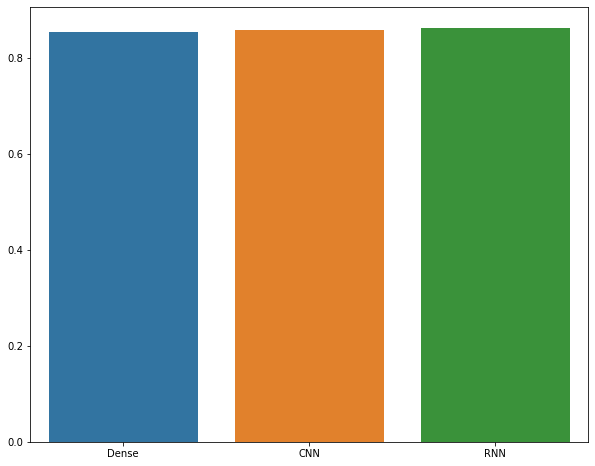

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot = sns.barplot(x=['Dense', 'CNN', 'RNN'], y=[d_acc, c_acc, r_acc])

Well thats not a very interesting graph because they all did so similar in performance. The last thing I am interested in is looking at how the learned embeddings vary across the models.

In [32]:
d_embed = dense.layers[0]
c_embed = cnn.layers[0]
r_embed = rnn.layers[0]

In [33]:
s = vectorizer(['bad'])
print(s[0,0])

tf.Tensor(83, shape=(), dtype=int64)


In [34]:
vocab[83]

'bad'

We have ectracted the embedding layers from each network and taken the sample word (the 497th word in our vocab) bad.

In [35]:
embeds = [d_embed(s)[0,0,:], c_embed(s)[0,0,:], r_embed(s)[0,0,:]]

In [36]:
print('Distance Dense and CNN: {}'.format(tf.norm(embeds[0]-embeds[1])))
print('Distance Dense and RNN: {}'.format(tf.norm(embeds[0]-embeds[2])))
print('Distance CNN and RNN: {}'.format(tf.norm(embeds[1]-embeds[2])))

Distance Dense and CNN: 1.7357908487319946
Distance Dense and RNN: 1.6810531616210938
Distance CNN and RNN: 1.4131357669830322


The embeddings are different as we would expect, but not too different. It would be more interesting to look at the differences using something like t-SNE, but I will save that for another time.

# Conclusion

In this notebook I looked at text-based binary setiment classification using three different neural network architechtures. The models I considered were quite simple, but I learned a lot in the process and I have a few major takeaways. First, in this case performance did not vary across model architechture. Based on my outside knowledge this implies that I need to be more nuanced about how I build my models, or that at this small scale variations are not visible. It is clear that recurrent models are much slower to train which can be a big downside. Second, it makes sense to use a pre-trained embedding for many tasks like the one considered here. Learning an embedding will only take time, resources (i.e. parameters), and will probably leave out some words. In the future I will use such an embedding trained an a very large corpus.